In [1]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from skimage import io

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [3]:
class imageDataset(Dataset):
    
    def __init__(self, frame1, frame2, frame3, root_dir, k):
        
        self.f1 = self.f2 = self.f3 = []
        self.root_dir = root_dir
        #for ls, pt in zip([self.f1, self.f2, self.f1], [frame1, frame2, frame3]):
        with open(frame1) as f:
            content = f.readlines()
        self.f1 = [x.strip() for x in content][k:k+1]
        
        with open(frame2) as f:
            content = f.readlines()
        self.f2 = [x.strip() for x in content][k:k+1]
        
        with open(frame3) as f:
            content = f.readlines()
        self.f3 = [x.strip() for x in content][k:k+1]
        
        self.cache = {}
        self.cache_size = 5000
    
    def __len__(self):
        return len(self.f1)

    
    def __getitem__(self, idx):
        
        #print(self.f1[:5])
        
        if idx in self.cache:
            return self.cache[idx]
        
        img1 = cv2.imread(os.path.join(self.root_dir, self.f1[idx])).astype(np.float32) / 255.0
        img2 = cv2.imread(os.path.join(self.root_dir, self.f2[idx])).astype(np.float32) / 255.0
        img3 = cv2.imread(os.path.join(self.root_dir, self.f3[idx])).astype(np.float32) / 255.0
        
        img1_ = np.moveaxis(img1, 2, 0)
        img2_ = np.moveaxis(img2, 2, 0)
        img3_ = np.moveaxis(img3, 2, 0)
        
        r = (torch.FloatTensor(img1_), torch.FloatTensor(img2_), torch.FloatTensor(img3_))
        
        if len(self.cache) < self.cache_size:
            self.cache[idx] = r
        
        return r

In [65]:
class MajorNet(torch.nn.Module):
    def __init__(self):
        super(MajorNet, self).__init__()
        self.moduleEncoder1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=5),
            torch.nn.ReLU(),
             torch.nn.Conv2d(32, 64, kernel_size=5),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 64, kernel_size=5),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 128, kernel_size=4, stride=2),
             torch.nn.ReLU(),
             torch.nn.Conv2d(128, 256, kernel_size=3, stride=2),
             torch.nn.ReLU(),
             torch.nn.Conv2d(256, 64, kernel_size=4),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 32, kernel_size=3)
        )
        self.moduleEncoder2 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=5),
            torch.nn.ReLU(),
             torch.nn.Conv2d(32, 64, kernel_size=5),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 64, kernel_size=5),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 128, kernel_size=4, stride=2),
             torch.nn.ReLU(),
             torch.nn.Conv2d(128, 256, kernel_size=3, stride=2),
             torch.nn.ReLU(),
             torch.nn.Conv2d(256, 64, kernel_size=4),
             torch.nn.ReLU(),
             torch.nn.Conv2d(64, 32, kernel_size=3)
        )
        
        self.moduleDecoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 256, kernel_size=4),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 64, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=5)
        )
    def forward(self, x, z):

        out1 = self.moduleEncoder1(x)
        out2 = self.moduleEncoder2(z)
        #print(type(out1), out1.shape)
        
        out3  = torch.cat((out2, out1), 1)
        #print('out3', out3.shape)
        out4 = self.moduleDecoder(out3)
        
        #print('out4',out4.shape)
        return out4


In [84]:
d = imageDataset('/home/mounted/data_major/f1.txt', '/home/mounted/data_major/f2.txt', '/home/mounted/data_major/f3.txt', '/home/mounted/data_major/crops/', 8)
#model_path = '/home/mounted/checkpoint.pth.tar'

In [6]:
def vis_output_img(out):
    out_ = out.cpu().data.numpy()
    n, channel, width, height = out_.shape
    out_ = np.reshape(out_, [channel, width, height])
    out_ = np.moveaxis(out_,0,-1) * 255.0
    out_ = out_.astype(np.uint8)
    plt.imshow(out_)
    plt.show()

In [86]:
num_epochs = 1000
model = MajorNet().cuda()


losses = AverageMeter()
losses.reset()

train_loader = DataLoader(d, batch_size=1, shuffle=False, num_workers=4)

loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [89]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [90]:
for epoch in range(num_epochs):
    #print("Epoch %d" % epoch)
    
    for i, (img1, img2, img3) in enumerate(train_loader):    # Ignore image labels
        
        out = model(Variable(img1).cuda(), Variable(img3).cuda())
        #print(out.shape)
        optimizer.zero_grad()
        loss = loss_fn(out, Variable(img2).cuda())
     #losses.update(loss.data[0] / (256*256*3), img1.size(0))
        
        loss.backward()
        optimizer.step()
        

    if (epoch+1) % 10 == 0 or not epoch:
        print(loss.data[0])
        #vis_output_img(out)
    #print("Loss = %.3f" % loss.data[0])


494.5430603027344
487.99835205078125
486.5862731933594
485.4612731933594
484.3454284667969
483.2329406738281
482.0942687988281
480.9497375488281
479.7903747558594
478.6194763183594
477.4346008300781
476.2285461425781
475.0133361816406
473.7815246582031
472.534423828125
471.2785949707031
470.0139465332031
468.737548828125
467.4416809082031
466.14935302734375
464.8486328125
463.5404968261719
462.2164001464844
460.8942565917969
459.57843017578125
458.2644348144531
456.9378967285156
455.6369323730469
454.310302734375
452.9726257324219
451.6528015136719
450.326904296875
448.99542236328125
447.6846008300781
446.3197937011719
444.9909362792969
443.6285095214844
442.2879333496094
440.95867919921875
439.5901794433594
438.232666015625
436.9158020019531
435.56158447265625
434.203369140625
432.88134765625
431.5548400878906
430.2142333984375
428.9052429199219
427.60650634765625
426.2508850097656
424.9403076171875
423.65740966796875
422.3497314453125
421.0274353027344
419.7144470214844
418.402954101

In [308]:
state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
}
torch.save(state, model_path)

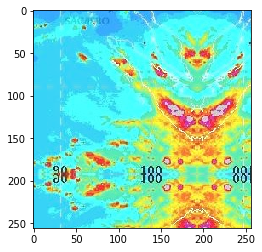

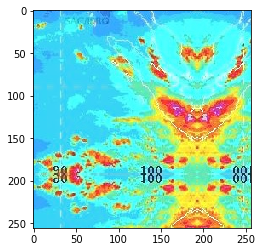

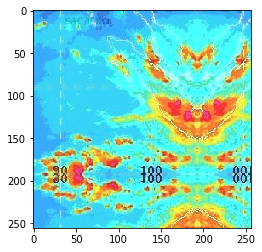

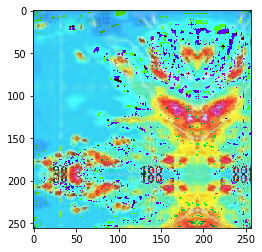

In [91]:
vis_output_img(Variable(img1))
vis_output_img(Variable(img2))
vis_output_img(Variable(img3))
vis_output_img(out)

In [92]:
out_ = out.cpu().data.numpy()
n, channel, width, height = out_.shape
out_ = np.reshape(out_, [channel, width, height])
out_ = np.moveaxis(out_,0,-1) * 255.0
out_ = out_.astype(np.uint8)
cv2.imwrite('/home/mounted/data_major/out_8.jpg', cv2.cvtColor(out_, cv2.COLOR_RGB2BGR))

True

# ends here

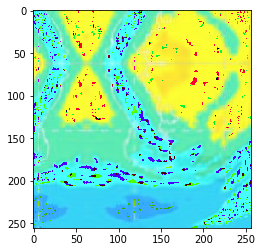

In [16]:
plt.imshow(out_)

In [93]:
vf = cv2.imread('/home/mounted/data_major/out.jpg')

In [94]:
sep = cv2.imread('/home/mounted/data_major/out2.jpg')

In [104]:
sep = cv2.cvtColor(np.array(sep, dtype=np.uint8), cv2.COLOR_RGB2BGR)

In [95]:
our = cv2.imread('/home/mounted/data_major/x.jpg')

In [107]:
cv2.imwrite('/home/mounted/data_major/y.jpg', sep)

True

In [96]:
gt = cv2.imread('/home/mounted/data_major/3DIMG_01FEB2018_2000_L1C_ASIA_MER_WV_TEMP.jpg')[82:724, 31:673]

In [98]:
gt.shape, vf.shape

((642, 642, 3), (642, 642, 3))

In [106]:
np.mean((gt-vf)**2)

56.23868168981279

In [102]:
np.mean((gt-our)**2)

50.15445793422036

In [105]:
np.mean((gt-sep)**2)

61.79533389621607

In [71]:
111919.2578125

106275.546875

26601.39453125

22587.759765625

Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
loss val=20678.005859375

Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
loss val=19237.6484375

Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
loss val=18467.306640625

Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
loss val=17406.810546875

Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
loss val=15101.291015625

Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
loss val=11582.1376953125

Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
loss val=7379.876953125

Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
loss val=5922.208984375

Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
loss val=5120.85205078125

Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
loss val=4543.7265625

Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
loss val=4310.09423828125

Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
loss val=3711.83935546875

Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
loss val=3182.060546875

Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
loss val=2694.9443359375

Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
loss val=2499.279296875

Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
loss val=2273.90771484375

Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
loss val=2056.374755859375

Epoch 200
Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
loss val=1879.32568359375

Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
loss val=2162.01953125

Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
loss val=1652.0577392578125

Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
loss val=1521.9007568359375

Epoch 240
Epoch 241
Epoch 242
Epoch 243
Epoch 244
Epoch 245
Epoch 246
Epoch 247
Epoch 248
Epoch 249
loss val=1414.2054443359375

Epoch 250
Epoch 251
Epoch 252
Epoch 253
Epoch 254
Epoch 255
Epoch 256
Epoch 257
Epoch 258
Epoch 259
loss val=1734.0933837890625

Epoch 260
Epoch 261
Epoch 262
Epoch 263
Epoch 264
Epoch 265
Epoch 266
Epoch 267
Epoch 268
Epoch 269
loss val=1399.75048828125

Epoch 270
Epoch 271
Epoch 272
Epoch 273
Epoch 274
Epoch 275
Epoch 276
Epoch 277
Epoch 278
Epoch 279
loss val=1289.529541015625

Epoch 280
Epoch 281
Epoch 282
Epoch 283
Epoch 284
Epoch 285
Epoch 286
Epoch 287
Epoch 288
Epoch 289
loss val=1182.4610595703125

Epoch 290
Epoch 291
Epoch 292
Epoch 293
Epoch 294
Epoch 295
Epoch 296
Epoch 297
Epoch 298
Epoch 299
loss val=1179.84130859375

Epoch 300
Epoch 301
Epoch 302
Epoch 303
Epoch 304
Epoch 305
Epoch 306
Epoch 307
Epoch 308
Epoch 309
loss val=1137.552001953125

Epoch 310
Epoch 311
Epoch 312
Epoch 313
Epoch 314
Epoch 315
Epoch 316
Epoch 317
Epoch 318
Epoch 319
loss val=1081.49462890625

Epoch 320
Epoch 321
Epoch 322
Epoch 323
Epoch 324
Epoch 325
Epoch 326
Epoch 327
Epoch 328
Epoch 329
loss val=971.0535888671875

Epoch 330
Epoch 331
Epoch 332
Epoch 333
Epoch 334
Epoch 335
Epoch 336
Epoch 337
Epoch 338
Epoch 339
loss val=1242.47802734375

Epoch 340
Epoch 341
Epoch 342
Epoch 343
Epoch 344
Epoch 345
Epoch 346
Epoch 347
Epoch 348
Epoch 349
loss val=1030.350341796875

Epoch 350
Epoch 351
Epoch 352
Epoch 353
Epoch 354
Epoch 355
Epoch 356
Epoch 357
Epoch 358
Epoch 359
loss val=891.2596435546875

Epoch 360
Epoch 361
Epoch 362
Epoch 363
Epoch 364
Epoch 365
Epoch 366
Epoch 367
Epoch 368
Epoch 369
loss val=865.7210693359375

Epoch 370
Epoch 371
Epoch 372
Epoch 373
Epoch 374
Epoch 375
Epoch 376
Epoch 377
Epoch 378
Epoch 379
loss val=788.8912353515625

Epoch 380
Epoch 381
Epoch 382
Epoch 383
Epoch 384
Epoch 385
Epoch 386
Epoch 387
Epoch 388
Epoch 389
loss val=765.0604858398438

Epoch 390
Epoch 391
Epoch 392
Epoch 393
Epoch 394
Epoch 395
Epoch 396
Epoch 397
Epoch 398
Epoch 399
loss val=793.9168701171875

Epoch 400
Epoch 401
Epoch 402
Epoch 403
Epoch 404
Epoch 405
Epoch 406
Epoch 407
Epoch 408
Epoch 409
loss val=713.2013549804688

Epoch 410
Epoch 411
Epoch 412
Epoch 413
Epoch 414
Epoch 415
Epoch 416
Epoch 417
Epoch 418
Epoch 419
loss val=763.1468505859375

Epoch 420
Epoch 421
Epoch 422
Epoch 423
Epoch 424
Epoch 425
Epoch 426
Epoch 427
Epoch 428
Epoch 429
loss val=891.5693969726562

Epoch 430
Epoch 431
Epoch 432
Epoch 433
Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
loss val=812.5153198242188

Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
loss val=684.8897094726562

Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
loss val=631.3646240234375

Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
loss val=631.7039184570312

Epoch 470
Epoch 471
Epoch 472
Epoch 473
Epoch 474
Epoch 475
Epoch 476
Epoch 477
Epoch 478
Epoch 479
loss val=591.7061767578125

Epoch 480
Epoch 481
Epoch 482
Epoch 483
Epoch 484
Epoch 485
Epoch 486
Epoch 487
Epoch 488
Epoch 489
loss val=582.4334716796875

Epoch 490
Epoch 491
Epoch 492
Epoch 493
Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
loss val=570.4871215820312

Epoch 500
Epoch 501
Epoch 502
Epoch 503
Epoch 504
Epoch 505
Epoch 506
Epoch 507
Epoch 508
Epoch 509
loss val=534.8125

Epoch 510
Epoch 511
Epoch 512
Epoch 513
Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
loss val=1188.27880859375

Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
loss val=688.8839721679688

Epoch 530
Epoch 531
Epoch 532
Epoch 533
Epoch 534
Epoch 535
Epoch 536
Epoch 537
Epoch 538
Epoch 539
loss val=607.247802734375

Epoch 540
Epoch 541
Epoch 542
Epoch 543
Epoch 544
Epoch 545
Epoch 546
Epoch 547
Epoch 548
Epoch 549
loss val=549.4811401367188

Epoch 550
Epoch 551
Epoch 552
Epoch 553
Epoch 554
Epoch 555
Epoch 556
Epoch 557
Epoch 558
Epoch 559
loss val=513.4951782226562

Epoch 560
Epoch 561
Epoch 562
Epoch 563
Epoch 564
Epoch 565
Epoch 566
Epoch 567
Epoch 568
Epoch 569
loss val=495.6953125

Epoch 570
Epoch 571
Epoch 572
Epoch 573
Epoch 574
Epoch 575
Epoch 576
Epoch 577
Epoch 578
Epoch 579
loss val=481.12744140625

Epoch 580
Epoch 581
Epoch 582
Epoch 583
Epoch 584
Epoch 585
Epoch 586
Epoch 587
Epoch 588
Epoch 589
loss val=468.8551025390625

Epoch 590
Epoch 591
Epoch 592
Epoch 593
Epoch 594
Epoch 595
Epoch 596
Epoch 597
Epoch 598
Epoch 599
loss val=457.6078796386719

Epoch 600
Epoch 601
Epoch 602
Epoch 603
Epoch 604
Epoch 605
Epoch 606
Epoch 607
Epoch 608
Epoch 609
loss val=468.90692138671875

Epoch 610
Epoch 611
Epoch 612
Epoch 613
Epoch 614
Epoch 615
Epoch 616
Epoch 617
Epoch 618
Epoch 619
loss val=468.6541748046875

Epoch 620
Epoch 621
Epoch 622
Epoch 623
Epoch 624
Epoch 625
Epoch 626
Epoch 627
Epoch 628
Epoch 629
loss val=458.7928466796875

Epoch 630
Epoch 631
Epoch 632
Epoch 633
Epoch 634
Epoch 635
Epoch 636
Epoch 637
Epoch 638
Epoch 639
loss val=438.01727294921875

Epoch 640
Epoch 641
Epoch 642
Epoch 643
Epoch 644
Epoch 645
Epoch 646
Epoch 647
Epoch 648
Epoch 649
loss val=431.13958740234375

Epoch 650
Epoch 651
Epoch 652
Epoch 653
Epoch 654
Epoch 655
Epoch 656
Epoch 657
Epoch 658
Epoch 659
loss val=425.9329833984375

Epoch 660
Epoch 661
Epoch 662
Epoch 663
Epoch 664
Epoch 665
Epoch 666
Epoch 667
Epoch 668
Epoch 669
loss val=724.8868408203125

Epoch 670
Epoch 671
Epoch 672
Epoch 673
Epoch 674
Epoch 675
Epoch 676
Epoch 677
Epoch 678
Epoch 679
loss val=552.4020385742188

Epoch 680
Epoch 681
Epoch 682
Epoch 683
Epoch 684
Epoch 685
Epoch 686
Epoch 687
Epoch 688
Epoch 689
loss val=454.6590881347656

Epoch 690
Epoch 691
Epoch 692
Epoch 693
Epoch 694
Epoch 695
Epoch 696
Epoch 697
Epoch 698
Epoch 699
loss val=419.4815368652344

Epoch 700
Epoch 701
Epoch 702
Epoch 703
Epoch 704
Epoch 705
Epoch 706
Epoch 707
Epoch 708
Epoch 709
loss val=402.7624206542969

Epoch 710
Epoch 711
Epoch 712
Epoch 713
Epoch 714
Epoch 715
Epoch 716
Epoch 717
Epoch 718
Epoch 719
loss val=391.00640869140625

Epoch 720
Epoch 721
Epoch 722
Epoch 723
Epoch 724
Epoch 725
Epoch 726
Epoch 727
Epoch 728
Epoch 729
loss val=383.3480224609375

Epoch 730
Epoch 731
Epoch 732
Epoch 733
Epoch 734
Epoch 735
Epoch 736
Epoch 737
Epoch 738
Epoch 739
loss val=376.9036865234375

Epoch 740
Epoch 741
Epoch 742
Epoch 743
Epoch 744
Epoch 745
Epoch 746
Epoch 747
Epoch 748
Epoch 749
loss val=371.7928466796875

Epoch 750
Epoch 751
Epoch 752
Epoch 753
Epoch 754
Epoch 755
Epoch 756
Epoch 757
Epoch 758
Epoch 759
loss val=365.51141357421875

Epoch 760
Epoch 761
Epoch 762
Epoch 763
Epoch 764
Epoch 765
Epoch 766
Epoch 767
Epoch 768
Epoch 769
loss val=483.142333984375

Epoch 770
Epoch 771
Epoch 772
Epoch 773
Epoch 774
Epoch 775
Epoch 776
Epoch 777
Epoch 778
Epoch 779
loss val=399.77020263671875

Epoch 780
Epoch 781
Epoch 782
Epoch 783
Epoch 784
Epoch 785
Epoch 786
Epoch 787
Epoch 788
Epoch 789
loss val=384.50189208984375

Epoch 790
Epoch 791
Epoch 792
Epoch 793
Epoch 794
Epoch 795
Epoch 796
Epoch 797
Epoch 798
Epoch 799
loss val=361.0198059082031

Epoch 800
Epoch 801
Epoch 802
Epoch 803
Epoch 804
Epoch 805
Epoch 806
Epoch 807
Epoch 808
Epoch 809
loss val=351.46112060546875

Epoch 810
Epoch 811
Epoch 812
Epoch 813
Epoch 814
Epoch 815
Epoch 816
Epoch 817
Epoch 818
Epoch 819
loss val=345.0669860839844

Epoch 820
Epoch 821
Epoch 822
Epoch 823
Epoch 824
Epoch 825
Epoch 826
Epoch 827
Epoch 828
Epoch 829
loss val=364.7652893066406

Epoch 830
Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
loss val=407.6149597167969

Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
loss val=384.244873046875

Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
loss val=418.8220520019531

Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
loss val=372.2101745605469

Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
loss val=340.8714294433594

Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
loss val=329.332763671875

Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
loss val=408.8764343261719

Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
loss val=365.4701232910156

Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
loss val=333.4501647949219

Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
loss val=335.09344482421875

Epoch 930
Epoch 931
Epoch 932
Epoch 933
Epoch 934
Epoch 935
Epoch 936
Epoch 937
Epoch 938
Epoch 939
loss val=323.05072021484375

Epoch 940
Epoch 941
Epoch 942
Epoch 943
Epoch 944
Epoch 945
Epoch 946
Epoch 947
Epoch 948
Epoch 949
loss val=348.6383056640625

Epoch 950
Epoch 951
Epoch 952
Epoch 953
Epoch 954
Epoch 955
Epoch 956
Epoch 957
Epoch 958
Epoch 959
loss val=329.3546142578125

Epoch 960
Epoch 961
Epoch 962
Epoch 963
Epoch 964
Epoch 965
Epoch 966
Epoch 967
Epoch 968
Epoch 969
loss val=330.7812805175781

Epoch 970
Epoch 971
Epoch 972
Epoch 973
Epoch 974
Epoch 975
Epoch 976
Epoch 977
Epoch 978
Epoch 979
loss val=342.34527587890625

Epoch 980
Epoch 981
Epoch 982
Epoch 983
Epoch 984
Epoch 985
Epoch 986
Epoch 987
Epoch 988
Epoch 989
loss val=313.0742492675781

Epoch 990
Epoch 991
Epoch 992
Epoch 993
Epoch 994
Epoch 995
Epoch 996
Epoch 997
Epoch 998
Epoch 999
loss val=306.74493408203125


SyntaxError: invalid syntax (<ipython-input-71-385d5af650c4>, line 1)

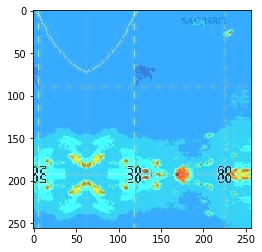

In [258]:
out_ = img1.numpy()
n, channel, width, height = out_.shape
out_ = np.reshape(out_, [channel, width, height])
out_ = np.moveaxis(out_,0,-1) * 255.0
out_ = out_.astype(np.uint8)
plt.imshow(out_)

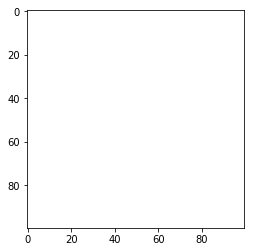

In [175]:
plt.imshow(np.moveaxis(np.squeeze(img1.numpy())*255,0,-1))

In [176]:
np.moveaxis(np.squeeze(img1.numpy())*255,0,-1)

array([[[ 88., 192., 255.],
        [ 53., 156., 218.],
        [120., 220., 255.],
        ...,
        [ 55., 171., 255.],
        [ 57., 171., 255.],
        [ 57., 171., 255.]],

       [[ 67., 174., 242.],
        [ 80., 184., 249.],
        [ 76., 177., 232.],
        ...,
        [ 55., 171., 255.],
        [ 57., 171., 255.],
        [ 57., 171., 255.]],

       [[ 62., 173., 246.],
        [ 58., 166., 237.],
        [ 92., 195., 255.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       ...,

       [[ 54., 171., 255.],
        [ 54., 171., 255.],
        [ 54., 168., 252.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       [[ 52., 171., 255.],
        [ 54., 171., 255.],
        [ 55., 170., 251.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       [[ 52., 171., 255.],
        [ 54., 172., 255.],
        [ 59., 1

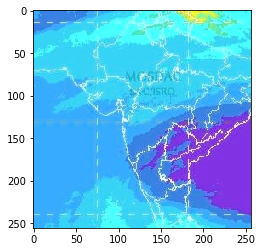

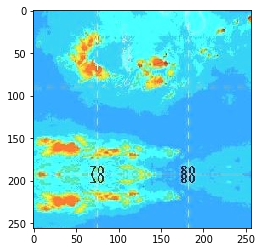

In [53]:
for x, y in enumerate(dataloader):
    #print(len(y))
    x1, x2, x3 = y[0][0], y[1][0], y[2][0]
    x_ = x1.view(-1, 256*256*3)
    #print(x1.shape, .shape)
    plt.imshow(np.reshape(x_, (256,256,3)))
    plt.show()

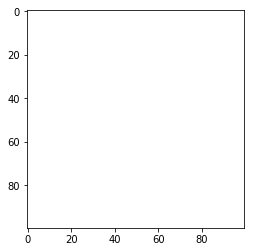

In [177]:
predict = img1.numpy()
n, channel, width, height = predict.shape
predict = np.reshape(predict, [channel, width, height])
predict = np.moveaxis(predict,0,-1) * 255
plt.imshow(predict)

In [179]:
predict

array([[[ 88., 192., 255.],
        [ 53., 156., 218.],
        [120., 220., 255.],
        ...,
        [ 55., 171., 255.],
        [ 57., 171., 255.],
        [ 57., 171., 255.]],

       [[ 67., 174., 242.],
        [ 80., 184., 249.],
        [ 76., 177., 232.],
        ...,
        [ 55., 171., 255.],
        [ 57., 171., 255.],
        [ 57., 171., 255.]],

       [[ 62., 173., 246.],
        [ 58., 166., 237.],
        [ 92., 195., 255.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       ...,

       [[ 54., 171., 255.],
        [ 54., 171., 255.],
        [ 54., 168., 252.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       [[ 52., 171., 255.],
        [ 54., 171., 255.],
        [ 55., 170., 251.],
        ...,
        [ 55., 171., 255.],
        [ 55., 171., 255.],
        [ 55., 171., 255.]],

       [[ 52., 171., 255.],
        [ 54., 172., 255.],
        [ 59., 1

In [182]:
x=os.path.join(d.root_dir, d.f1[0])

In [199]:
image = cv2.imread(x)/ 255.0
image = np.moveaxis(image,2,0)
image = np.reshape(image,(1,) + image.shape)

input = torch.from_numpy(image).type(torch.FloatTensor)
#predict = self.model(Variable(input))

predict = input.numpy()
n, channel, width, height = predict.shape
predict = np.reshape(predict, [channel, width, height])
predict = np.moveaxis(predict,0,-1) * 255.0
predict = predict.astype(np.uint8)

In [221]:
plt.imshow(predict__.astype(np.uint8), cmap='gray')

NameError: name 'predict__' is not defined

In [192]:
predict.shape

(256, 256, 3)

In [74]:
z='loss val=111919.2578125

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
loss val=106275.546875

Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
loss val=26601.39453125

Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
loss val=22587.759765625

Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
loss val=20678.005859375

Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
loss val=19237.6484375

Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
loss val=18467.306640625

Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
loss val=17406.810546875

Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
loss val=15101.291015625

Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
loss val=11582.1376953125

Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
loss val=7379.876953125

Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
loss val=5922.208984375

Epoch 110
Epoch 111
Epoch 112
Epoch 113
Epoch 114
Epoch 115
Epoch 116
Epoch 117
Epoch 118
Epoch 119
loss val=5120.85205078125

Epoch 120
Epoch 121
Epoch 122
Epoch 123
Epoch 124
Epoch 125
Epoch 126
Epoch 127
Epoch 128
Epoch 129
loss val=4543.7265625

Epoch 130
Epoch 131
Epoch 132
Epoch 133
Epoch 134
Epoch 135
Epoch 136
Epoch 137
Epoch 138
Epoch 139
loss val=4310.09423828125

Epoch 140
Epoch 141
Epoch 142
Epoch 143
Epoch 144
Epoch 145
Epoch 146
Epoch 147
Epoch 148
Epoch 149
loss val=3711.83935546875

Epoch 150
Epoch 151
Epoch 152
Epoch 153
Epoch 154
Epoch 155
Epoch 156
Epoch 157
Epoch 158
Epoch 159
loss val=3182.060546875

Epoch 160
Epoch 161
Epoch 162
Epoch 163
Epoch 164
Epoch 165
Epoch 166
Epoch 167
Epoch 168
Epoch 169
loss val=2694.9443359375

Epoch 170
Epoch 171
Epoch 172
Epoch 173
Epoch 174
Epoch 175
Epoch 176
Epoch 177
Epoch 178
Epoch 179
loss val=2499.279296875

Epoch 180
Epoch 181
Epoch 182
Epoch 183
Epoch 184
Epoch 185
Epoch 186
Epoch 187
Epoch 188
Epoch 189
loss val=2273.90771484375

Epoch 190
Epoch 191
Epoch 192
Epoch 193
Epoch 194
Epoch 195
Epoch 196
Epoch 197
Epoch 198
Epoch 199
loss val=2056.374755859375

Epoch 200
Epoch 201
Epoch 202
Epoch 203
Epoch 204
Epoch 205
Epoch 206
Epoch 207
Epoch 208
Epoch 209
loss val=1879.32568359375

Epoch 210
Epoch 211
Epoch 212
Epoch 213
Epoch 214
Epoch 215
Epoch 216
Epoch 217
Epoch 218
Epoch 219
loss val=2162.01953125

Epoch 220
Epoch 221
Epoch 222
Epoch 223
Epoch 224
Epoch 225
Epoch 226
Epoch 227
Epoch 228
Epoch 229
loss val=1652.0577392578125

Epoch 230
Epoch 231
Epoch 232
Epoch 233
Epoch 234
Epoch 235
Epoch 236
Epoch 237
Epoch 238
Epoch 239
loss val=1521.9007568359375

Epoch 240
Epoch 241
Epoch 242
Epoch 243
Epoch 244
Epoch 245
Epoch 246
Epoch 247
Epoch 248
Epoch 249
loss val=1414.2054443359375

Epoch 250
Epoch 251
Epoch 252
Epoch 253
Epoch 254
Epoch 255
Epoch 256
Epoch 257
Epoch 258
Epoch 259
loss val=1734.0933837890625

Epoch 260
Epoch 261
Epoch 262
Epoch 263
Epoch 264
Epoch 265
Epoch 266
Epoch 267
Epoch 268
Epoch 269
loss val=1399.75048828125

Epoch 270
Epoch 271
Epoch 272
Epoch 273
Epoch 274
Epoch 275
Epoch 276
Epoch 277
Epoch 278
Epoch 279
loss val=1289.529541015625

Epoch 280
Epoch 281
Epoch 282
Epoch 283
Epoch 284
Epoch 285
Epoch 286
Epoch 287
Epoch 288
Epoch 289
loss val=1182.4610595703125

Epoch 290
Epoch 291
Epoch 292
Epoch 293
Epoch 294
Epoch 295
Epoch 296
Epoch 297
Epoch 298
Epoch 299
loss val=1179.84130859375

Epoch 300
Epoch 301
Epoch 302
Epoch 303
Epoch 304
Epoch 305
Epoch 306
Epoch 307
Epoch 308
Epoch 309
loss val=1137.552001953125

Epoch 310
Epoch 311
Epoch 312
Epoch 313
Epoch 314
Epoch 315
Epoch 316
Epoch 317
Epoch 318
Epoch 319
loss val=1081.49462890625

Epoch 320
Epoch 321
Epoch 322
Epoch 323
Epoch 324
Epoch 325
Epoch 326
Epoch 327
Epoch 328
Epoch 329
loss val=971.0535888671875

Epoch 330
Epoch 331
Epoch 332
Epoch 333
Epoch 334
Epoch 335
Epoch 336
Epoch 337
Epoch 338
Epoch 339
loss val=1242.47802734375

Epoch 340
Epoch 341
Epoch 342
Epoch 343
Epoch 344
Epoch 345
Epoch 346
Epoch 347
Epoch 348
Epoch 349
loss val=1030.350341796875

Epoch 350
Epoch 351
Epoch 352
Epoch 353
Epoch 354
Epoch 355
Epoch 356
Epoch 357
Epoch 358
Epoch 359
loss val=891.2596435546875

Epoch 360
Epoch 361
Epoch 362
Epoch 363
Epoch 364
Epoch 365
Epoch 366
Epoch 367
Epoch 368
Epoch 369
loss val=865.7210693359375

Epoch 370
Epoch 371
Epoch 372
Epoch 373
Epoch 374
Epoch 375
Epoch 376
Epoch 377
Epoch 378
Epoch 379
loss val=788.8912353515625

Epoch 380
Epoch 381
Epoch 382
Epoch 383
Epoch 384
Epoch 385
Epoch 386
Epoch 387
Epoch 388
Epoch 389
loss val=765.0604858398438

Epoch 390
Epoch 391
Epoch 392
Epoch 393
Epoch 394
Epoch 395
Epoch 396
Epoch 397
Epoch 398
Epoch 399
loss val=793.9168701171875

Epoch 400
Epoch 401
Epoch 402
Epoch 403
Epoch 404
Epoch 405
Epoch 406
Epoch 407
Epoch 408
Epoch 409
loss val=713.2013549804688

Epoch 410
Epoch 411
Epoch 412
Epoch 413
Epoch 414
Epoch 415
Epoch 416
Epoch 417
Epoch 418
Epoch 419
loss val=763.1468505859375

Epoch 420
Epoch 421
Epoch 422
Epoch 423
Epoch 424
Epoch 425
Epoch 426
Epoch 427
Epoch 428
Epoch 429
loss val=891.5693969726562

Epoch 430
Epoch 431
Epoch 432
Epoch 433
Epoch 434
Epoch 435
Epoch 436
Epoch 437
Epoch 438
Epoch 439
loss val=812.5153198242188

Epoch 440
Epoch 441
Epoch 442
Epoch 443
Epoch 444
Epoch 445
Epoch 446
Epoch 447
Epoch 448
Epoch 449
loss val=684.8897094726562

Epoch 450
Epoch 451
Epoch 452
Epoch 453
Epoch 454
Epoch 455
Epoch 456
Epoch 457
Epoch 458
Epoch 459
loss val=631.3646240234375

Epoch 460
Epoch 461
Epoch 462
Epoch 463
Epoch 464
Epoch 465
Epoch 466
Epoch 467
Epoch 468
Epoch 469
loss val=631.7039184570312

Epoch 470
Epoch 471
Epoch 472
Epoch 473
Epoch 474
Epoch 475
Epoch 476
Epoch 477
Epoch 478
Epoch 479
loss val=591.7061767578125

Epoch 480
Epoch 481
Epoch 482
Epoch 483
Epoch 484
Epoch 485
Epoch 486
Epoch 487
Epoch 488
Epoch 489
loss val=582.4334716796875

Epoch 490
Epoch 491
Epoch 492
Epoch 493
Epoch 494
Epoch 495
Epoch 496
Epoch 497
Epoch 498
Epoch 499
loss val=570.4871215820312

Epoch 500
Epoch 501
Epoch 502
Epoch 503
Epoch 504
Epoch 505
Epoch 506
Epoch 507
Epoch 508
Epoch 509
loss val=534.8125

Epoch 510
Epoch 511
Epoch 512
Epoch 513
Epoch 514
Epoch 515
Epoch 516
Epoch 517
Epoch 518
Epoch 519
loss val=1188.27880859375

Epoch 520
Epoch 521
Epoch 522
Epoch 523
Epoch 524
Epoch 525
Epoch 526
Epoch 527
Epoch 528
Epoch 529
loss val=688.8839721679688

Epoch 530
Epoch 531
Epoch 532
Epoch 533
Epoch 534
Epoch 535
Epoch 536
Epoch 537
Epoch 538
Epoch 539
loss val=607.247802734375

Epoch 540
Epoch 541
Epoch 542
Epoch 543
Epoch 544
Epoch 545
Epoch 546
Epoch 547
Epoch 548
Epoch 549
loss val=549.4811401367188

Epoch 550
Epoch 551
Epoch 552
Epoch 553
Epoch 554
Epoch 555
Epoch 556
Epoch 557
Epoch 558
Epoch 559
loss val=513.4951782226562

Epoch 560
Epoch 561
Epoch 562
Epoch 563
Epoch 564
Epoch 565
Epoch 566
Epoch 567
Epoch 568
Epoch 569
loss val=495.6953125

Epoch 570
Epoch 571
Epoch 572
Epoch 573
Epoch 574
Epoch 575
Epoch 576
Epoch 577
Epoch 578
Epoch 579
loss val=481.12744140625

Epoch 580
Epoch 581
Epoch 582
Epoch 583
Epoch 584
Epoch 585
Epoch 586
Epoch 587
Epoch 588
Epoch 589
loss val=468.8551025390625

Epoch 590
Epoch 591
Epoch 592
Epoch 593
Epoch 594
Epoch 595
Epoch 596
Epoch 597
Epoch 598
Epoch 599
loss val=457.6078796386719

Epoch 600
Epoch 601
Epoch 602
Epoch 603
Epoch 604
Epoch 605
Epoch 606
Epoch 607
Epoch 608
Epoch 609
loss val=468.90692138671875

Epoch 610
Epoch 611
Epoch 612
Epoch 613
Epoch 614
Epoch 615
Epoch 616
Epoch 617
Epoch 618
Epoch 619
loss val=468.6541748046875

Epoch 620
Epoch 621
Epoch 622
Epoch 623
Epoch 624
Epoch 625
Epoch 626
Epoch 627
Epoch 628
Epoch 629
loss val=458.7928466796875

Epoch 630
Epoch 631
Epoch 632
Epoch 633
Epoch 634
Epoch 635
Epoch 636
Epoch 637
Epoch 638
Epoch 639
loss val=438.01727294921875

Epoch 640
Epoch 641
Epoch 642
Epoch 643
Epoch 644
Epoch 645
Epoch 646
Epoch 647
Epoch 648
Epoch 649
loss val=431.13958740234375

Epoch 650
Epoch 651
Epoch 652
Epoch 653
Epoch 654
Epoch 655
Epoch 656
Epoch 657
Epoch 658
Epoch 659
loss val=425.9329833984375

Epoch 660
Epoch 661
Epoch 662
Epoch 663
Epoch 664
Epoch 665
Epoch 666
Epoch 667
Epoch 668
Epoch 669
loss val=724.8868408203125

Epoch 670
Epoch 671
Epoch 672
Epoch 673
Epoch 674
Epoch 675
Epoch 676
Epoch 677
Epoch 678
Epoch 679
loss val=552.4020385742188

Epoch 680
Epoch 681
Epoch 682
Epoch 683
Epoch 684
Epoch 685
Epoch 686
Epoch 687
Epoch 688
Epoch 689
loss val=454.6590881347656

Epoch 690
Epoch 691
Epoch 692
Epoch 693
Epoch 694
Epoch 695
Epoch 696
Epoch 697
Epoch 698
Epoch 699
loss val=419.4815368652344

Epoch 700
Epoch 701
Epoch 702
Epoch 703
Epoch 704
Epoch 705
Epoch 706
Epoch 707
Epoch 708
Epoch 709
loss val=402.7624206542969

Epoch 710
Epoch 711
Epoch 712
Epoch 713
Epoch 714
Epoch 715
Epoch 716
Epoch 717
Epoch 718
Epoch 719
loss val=391.00640869140625

Epoch 720
Epoch 721
Epoch 722
Epoch 723
Epoch 724
Epoch 725
Epoch 726
Epoch 727
Epoch 728
Epoch 729
loss val=383.3480224609375

Epoch 730
Epoch 731
Epoch 732
Epoch 733
Epoch 734
Epoch 735
Epoch 736
Epoch 737
Epoch 738
Epoch 739
loss val=376.9036865234375

Epoch 740
Epoch 741
Epoch 742
Epoch 743
Epoch 744
Epoch 745
Epoch 746
Epoch 747
Epoch 748
Epoch 749
loss val=371.7928466796875

Epoch 750
Epoch 751
Epoch 752
Epoch 753
Epoch 754
Epoch 755
Epoch 756
Epoch 757
Epoch 758
Epoch 759
loss val=365.51141357421875

Epoch 760
Epoch 761
Epoch 762
Epoch 763
Epoch 764
Epoch 765
Epoch 766
Epoch 767
Epoch 768
Epoch 769
loss val=483.142333984375

Epoch 770
Epoch 771
Epoch 772
Epoch 773
Epoch 774
Epoch 775
Epoch 776
Epoch 777
Epoch 778
Epoch 779
loss val=399.77020263671875

Epoch 780
Epoch 781
Epoch 782
Epoch 783
Epoch 784
Epoch 785
Epoch 786
Epoch 787
Epoch 788
Epoch 789
loss val=384.50189208984375

Epoch 790
Epoch 791
Epoch 792
Epoch 793
Epoch 794
Epoch 795
Epoch 796
Epoch 797
Epoch 798
Epoch 799
loss val=361.0198059082031

Epoch 800
Epoch 801
Epoch 802
Epoch 803
Epoch 804
Epoch 805
Epoch 806
Epoch 807
Epoch 808
Epoch 809
loss val=351.46112060546875

Epoch 810
Epoch 811
Epoch 812
Epoch 813
Epoch 814
Epoch 815
Epoch 816
Epoch 817
Epoch 818
Epoch 819
loss val=345.0669860839844

Epoch 820
Epoch 821
Epoch 822
Epoch 823
Epoch 824
Epoch 825
Epoch 826
Epoch 827
Epoch 828
Epoch 829
loss val=364.7652893066406

Epoch 830
Epoch 831
Epoch 832
Epoch 833
Epoch 834
Epoch 835
Epoch 836
Epoch 837
Epoch 838
Epoch 839
loss val=407.6149597167969

Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
loss val=384.244873046875

Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
loss val=418.8220520019531

Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
loss val=372.2101745605469

Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
loss val=340.8714294433594

Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
loss val=329.332763671875

Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
loss val=408.8764343261719

Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
loss val=365.4701232910156

Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
loss val=333.4501647949219

Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
loss val=335.09344482421875

Epoch 930
Epoch 931
Epoch 932
Epoch 933
Epoch 934
Epoch 935
Epoch 936
Epoch 937
Epoch 938
Epoch 939
loss val=323.05072021484375

Epoch 940
Epoch 941
Epoch 942
Epoch 943
Epoch 944
Epoch 945
Epoch 946
Epoch 947
Epoch 948
Epoch 949
loss val=348.6383056640625

Epoch 950
Epoch 951
Epoch 952
Epoch 953
Epoch 954
Epoch 955
Epoch 956
Epoch 957
Epoch 958
Epoch 959
loss val=329.3546142578125

Epoch 960
Epoch 961
Epoch 962
Epoch 963
Epoch 964
Epoch 965
Epoch 966
Epoch 967
Epoch 968
Epoch 969
loss val=330.7812805175781

Epoch 970
Epoch 971
Epoch 972
Epoch 973
Epoch 974
Epoch 975
Epoch 976
Epoch 977
Epoch 978
Epoch 979
loss val=342.34527587890625

Epoch 980
Epoch 981
Epoch 982
Epoch 983
Epoch 984
Epoch 985
Epoch 986
Epoch 987
Epoch 988
Epoch 989
loss val=313.0742492675781

Epoch 990
Epoch 991
Epoch 992
Epoch 993
Epoch 994
Epoch 995
Epoch 996
Epoch 997
Epoch 998
Epoch 999
loss val=306.74493408203125
'

SyntaxError: EOL while scanning string literal (<ipython-input-74-f49e0dd3d157>, line 1)

In [ ]:
printz